In [27]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
strip_first = lambda x: int(str(x)[0])
strip_first_vec = np.vectorize(strip_first)
strip_second = lambda x: int(str(x)[1])
strip_second_vec = np.vectorize(strip_second)

parser = lambda row: row.text.split('\n')[2:-1]

np.random.seed(42)

In [15]:
url = 'https://county.milwaukee.gov/EN/County-Clerk/Off-Nav/Election-Results/Election-Results-Fall-2020'
r = requests.get(url)

In [19]:
bs_data = bs(r.text, 'html.parser')
precinct = bs_data.findAll('table', {'class': 'precinctTable'})[1]


In [20]:
#Parse html
table_rows = precinct.find_all('tr')
header = parser(table_rows[0])

#Simplify header
header = ['Ward', 'Biden', 'Trump','Blankenship','Carroll','Jorgenson','write_in']
data = [parser(item) for item in table_rows[1:-1]]

#Make a dataframe
df = pd.DataFrame(data,columns=header)
df[header[1:]] = df[header[1:]].apply(pd.to_numeric)

#Calculate the total votes in a ward
df['total_votes'] = df[header[1:]].sum(axis=1)
#Drop anywhere that has not reported any votes
df = df[df.total_votes > 0]
df


,Ward,Biden,Trump,Blankenship,Carroll,Jorgenson,write_in,total_votes
0,City of Milwaukee Ward 1,974,190,5,5,2,6,1182
1,City of Milwaukee Ward 2,323,28,0,3,1,1,356
2,City of Milwaukee Ward 3,718,146,1,3,1,4,873
3,City of Milwaukee Ward 4,1257,188,4,8,4,7,1468
4,City of Milwaukee Ward 5,660,102,1,5,2,3,773
...,...,...,...,...,...,...,...,...
473,"V. Whitefish Bay Wards 5,6",1148,501,0,7,4,8,1668
474,V. Whitefish Bay Ward 7,614,208,1,3,2,5,833
475,"V. Whitefish Bay Wards 8,10",1344,483,1,13,1,2,1844
476,"V. Whitefish Bay Wards 9,11",1211,378,1,21,2,2,1615


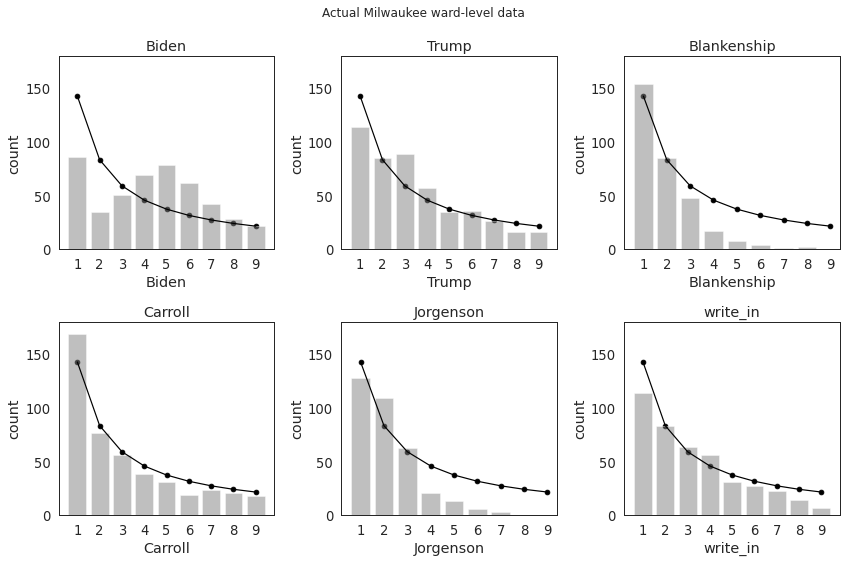

In [21]:
#Let's regenerate that plot that's been floating around. 

def plot_benford(who, df,ymax=180):
    sns.countplot(x=df[who].apply(strip_first), color='grey',
              order = [1,2,3,4,5,6,7,8,9],
              alpha=.5)
    plt.scatter(np.arange(9),
                np.log10(1 + 1/(np.arange(9)+1))*df[who].shape[0],
               color='black')
    plt.plot(np.arange(9),
                np.log10(1 + 1/(np.arange(9)+1))*df[who].shape[0],
               color='black')
    plt.title(who)
    plt.ylim(0,ymax)
    
plt.figure(figsize=(12,8))
plt.suptitle('Actual Milwaukee ward-level data')


sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

for idx,who in enumerate(header[1:]):
    plt.subplot(2,3,idx+1)
    plot_benford(who,df)
plt.tight_layout()

<h2>Digging Deeper</h2>

<h3>Hypothesis 1: Numbers are made up</h3>

<p>The above plot is as far as armchair statisticians went, demonstrating that there is a deviation from expected values from Benford's curve, without explanation. They implied or direclty stated that the deviations for Biden were a result of the total numbers being fabricated by humans.</p> 

<p>If the results were truly a random sample of voters, the logic goes, Benford's law would apply. Lucky for us, we can simulate that. For each ward and candidate, we simulate a random number of voters consistent with the expected percentage of votes for that candidate.</p> 

<p>If some conspiracy and fraud produced the distribution of intial digits, randomizing the vote totals removes any human hand in jotting the numbers down. If we still see the violations off Benford's law, something other than human-fudged numbers is going on</p>

<b>Prediction: If numbers are made up at precinct level, randomly regeneratign them should restore Benford's law</b>


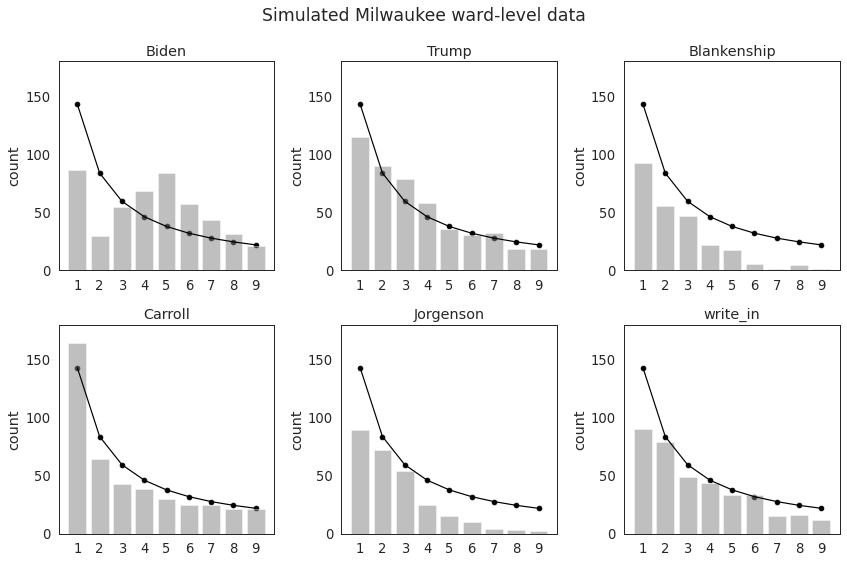

In [22]:
#Now, let's press the claim that the numbers are fake by randomly generating them
#with the same average proportions of votes

def plot_benford_simulated(who, df,ymax=180):
    
    #This is the key bit. We're not longer using the totals. 
    counts = np.random.binomial(df['total_votes'],
                       p=df[who].values/df['total_votes'].values)
    
    sns.countplot(x=strip_first_vec(counts), color='grey',
              order = [1,2,3,4,5,6,7,8,9],
              alpha=.5)

    plt.scatter(np.arange(9),
                np.log10(1 + 1/(np.arange(9)+1))*df[who].shape[0],
               color='black')
    plt.plot(np.arange(9),
                np.log10(1 + 1/(np.arange(9)+1))*df[who].shape[0],
               color='black')
    plt.title(who)
    plt.ylim(0,ymax)
    
plt.figure(figsize=(12,8))
plt.suptitle('Simulated Milwaukee ward-level data')

sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

for idx,who in enumerate(header[1:]):
    plt.subplot(2,3,idx+1)
    plot_benford_simulated(who,df)
plt.tight_layout()

<b>Result: Benford's law still appears broken even with randomly generated numbers. Something other than fabricated data is going on.</b>

<h3>Hypothesis 2: Not fraud, just an artifact of Ward Size</h3>

<p> Someone assigning vote totals does not explain the violation from benfords law for reasons scene above. 
    
In other words, no one is putting an excess of 4s, 5s, and 6's in the vote totals. This rules out Benford-detectable fraud at the level of precinct reporting, but we want more. Why do we see so may 4s, 5s and 6s? We want an explanation for why this is occuring. 
    
Benford's law requires that numbers occur across many orders of magnitude. In other words, we need things in the 1s, 10s, 100s, 1000s, 1000s. It's possible one candidates vote totals better follows Benford's law because it spans wider orders of magnitude. We can plot this to see if this is feasible. We add the most voted for third-party candidate as a sanity check.</p>

(0.0, 4.0)

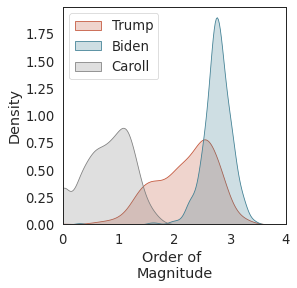

In [23]:
pal = sns.diverging_palette(220, 20, as_cmap=False, n=3)
plt.figure(figsize=(4,4))
sns.kdeplot(np.log10(df[df['Trump']!=0]['Trump'].values,),
             label='Trump', color=pal[2],shade=True,clip=[0,4])
sns.kdeplot(np.log10(df[df['Biden']!=0]['Biden']),
             label='Biden',color=pal[0],shade=True,clip=[0,4])
sns.kdeplot(np.log10(df[df['Carroll']!=0]['Carroll']),
             label='Caroll',color='Grey',shade=True,clip=[0,4])
plt.xlabel('Order of \nMagnitude')
plt.legend(loc='upper left')
plt.xlim(0, 4)

<p>This all feels a bit abstract though, and it's hard to exactly see what's going on </p> 


<p>To really drill down, we just need a scatterplot.</p>

/home/joseph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


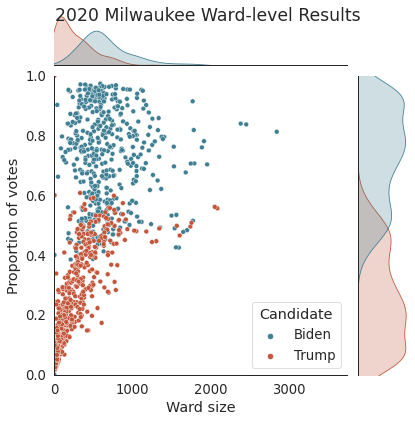

In [26]:
temp = pd.melt(df,id_vars=['Ward', 'total_votes'])
temp['proportion'] = temp['value'] / temp['total_votes']
temp = temp[(temp['variable']=='Biden') |( temp['variable']=='Trump')]

temp['Candidate'] = temp['variable']
h = sns.jointplot( x="value", y="proportion",hue='Candidate', data=temp,palette=[pal[0], pal[2]],
          ylim=(0,1),xlim=(0,np.max(temp['total_votes'])))

# JointGrid has a convenience function
h.set_axis_labels('Ward size','Proportion of votes')
plt.suptitle('2020 Milwaukee Ward-level Results')

plt.savefig('./BenfordBullshitMilwaukee.png',fmt='.png', dpi=500)

<p>

<p>We note that the majority of the votes went to Biden. This makes sense given that Milwaukee historically leans blue. If we just plot this againt the district size, our mystery is solved.</p> 

<p>By comparison, Trump only held on to 10-50% of the vote in these districts so his distribution looks more like Benford's law is holding</p> 
    
<strong>If you carry 50-95% of districts that are on average just shy of 1000 voters, you're gonna see a lot of 5,6,and 7's. There is *absolutely* nothing weird about this, just armchair data-scientists pushing disinformation.
</strong>

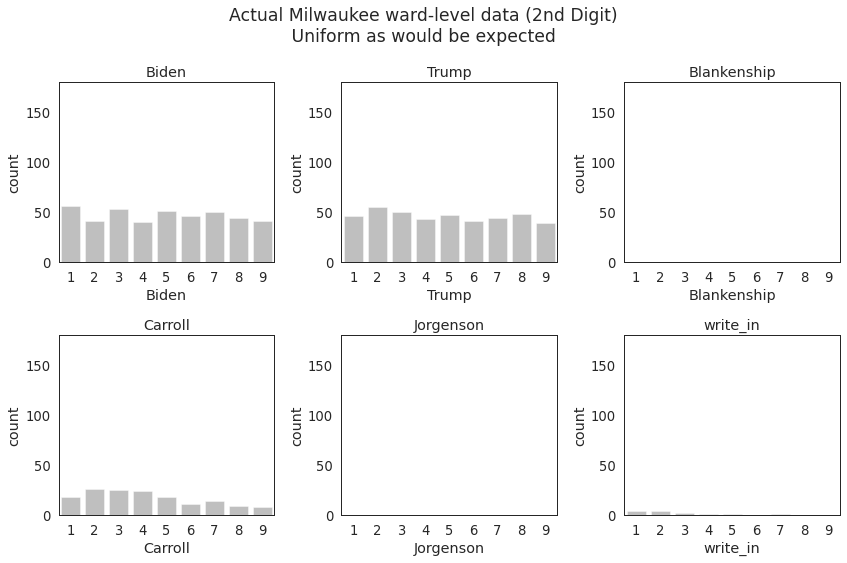

In [36]:
#Let's regenerate that plot that's been floating around. 

def plot_benford(who, df,ymax=180):
    temp = df[df[who] > 10]
    sns.countplot(x=temp[who].apply(strip_second), color='grey',
              order = [1,2,3,4,5,6,7,8,9],
              alpha=.5)

    plt.title(who)
    plt.ylim(0,ymax)
    
plt.figure(figsize=(12,8))
plt.suptitle('Actual Milwaukee ward-level data (2nd Digit)\n Uniform as would be expected ')


sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

for idx,who in enumerate(header[1:]):
    plt.subplot(2,3,idx+1)
    plot_benford(who,df)
plt.tight_layout()